In [81]:
from app.models import Session, Headline, Article, Agency
from app.queries import Queries
s = Session()

articles = Queries.get_todays_articles(s).all()
articles


[Article(id=105790, agency='Red State', url='https://redstate.com/alexparker/2024/03/01/jeopardy-goes-woke-gets-glazed-over-question-about-parts-of-speech-n2170796'),
 Article(id=105791, agency='The Federalist', url='https://thefederalist.com/2024/03/01/florida-academy-proves-school-choice-doesnt-have-to-mean-government-strings-attached/'),
 Article(id=105792, agency='HuffPost', url='https://www.huffpost.com/entry/texas-abortion-ban-domestic-violence_n_65dcd9a9e4b005b858312158'),
 Article(id=105795, agency='Reason', url='https://reason.com/puzzle/2024/03/01/license-to-chill-puzzle-31/'),
 Article(id=105800, agency='India Times', url='https://www.indiatimes.com/ampstories/entertainment/anant-ambanis-weight-loss-journey-628829.html'),
 Article(id=105803, agency='CBS News', url='https://www.cbsnews.com/news/menendez-brothers-await-decision-they-hope-will-free-them-48-hours/'),
 Article(id=105804, agency='Global Times', url='https://www.globaltimes.cn/page/202403/1308007.shtml'),
 Article(

In [82]:
import pandas as pd
df = pd.DataFrame([[a.most_recent_headline().title, a.last_accessed, a.agency.name] for a in articles], columns=['headline', 'last_accessed', 'agency'])
df.head()

,headline,last_accessed,agency
0,"'Jeopardy!' Goes Woke, Gets Shredded Over 'Par...",2024-03-02 17:10:00.478535,Red State
1,Florida Academy Proves School Choice Doesn’t H...,2024-03-02 17:10:01.692181,The Federalist
2,How Texas Created A Deadly New Normal For Dome...,2024-03-02 17:10:02.396437,HuffPost
3,License to Chill: Puzzle #31,2024-03-02 17:10:02.143595,Reason
4,Anant Ambani's Weight Loss Journey,2024-03-02 17:10:04.302634,India Times


In [83]:
repr_sample = df[df['headline'].str.contains('Musk')].iloc[2].headline
repr_sample

'Elon Musk suing OpenAI and Sam Altman for breaching not for profit mission'

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from app.pipelines import Pipelines, prepare, trem, tnorm, STOPWORDS

pipeline = [
    str.lower,
    Pipelines.split_camelcase,
    tnorm.hyphenated_words,
    tnorm.quotation_marks,
    tnorm.unicode,
    tnorm.whitespace,
    trem.accents,
    trem.brackets,
    trem.punctuation,
    Pipelines.tokenize,
    Pipelines.decontract,
    lambda x: Pipelines.remove_stop(x, STOPWORDS),
    # lambda x: ' '.join(x)
]

tfidf = TfidfVectorizer(
    tokenizer=lambda x: prepare(x, pipeline),
    max_features=1000
)
dt = tfidf.fit_transform(df['headline'])

/Users/mas/_dev/maudlin2/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [85]:
rep = tfidf.transform([repr_sample])

In [86]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(dt, rep)

array([[0.        ],
       [0.09638404],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [87]:
df['similarity'] = cosine_similarity(dt, rep)
df = df.sort_values('similarity', ascending=False)

In [98]:
len(df[df['similarity'] > 0.5])

16

<Axes: >

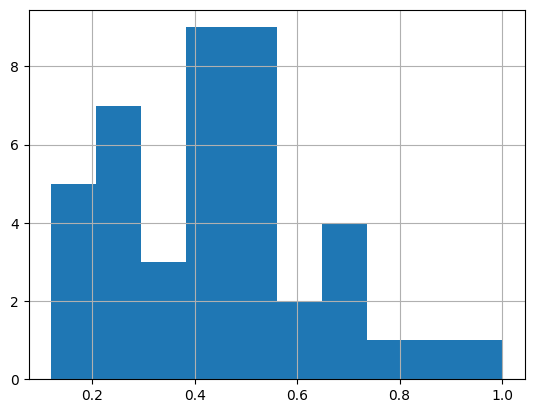

In [99]:
df[df['headline'].str.contains('Musk')]['similarity'].hist()

In [105]:
cutoff = 0.4
print("Full len:", len(df[df['similarity'] > cutoff]))
df[df['similarity'] > cutoff].sort_values('similarity', ascending=True).head(10)
contains = len(df[(df['similarity'] > cutoff) & (df['headline'].str.contains('Musk'))])
doesnt = len(df[(df['similarity'] > cutoff) & (~df['headline'].str.contains('Musk'))])
print("Contains:", contains)
print("Doesn't:", doesnt)
ratio = contains / (contains + doesnt)
print("Ratio:", ratio)


Full len: 27
Contains: 25
Doesn't: 2
Ratio: 0.9259259259259259


In [51]:
import numpy as np
tfidf.get_feature_names_out()

array([' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b',
       'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o',
       'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ं', 'अ',
       'आ', 'इ', 'ई', 'उ', 'ए', 'ऐ', 'ओ', 'क', 'ख', 'ग', 'च', 'छ', 'ज',
       'झ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ',
       'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि',
       'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '\u200d'], dtype=object)

In [116]:
from sklearn.feature_extraction.text import CountVectorizer

def xkeyscore(representations, x):
    cv = CountVectorizer(
        tokenizer=lambda x: prepare(x, pipeline),
        max_features=20,
        ngram_range=(1, 3),
        lowercase=False
    ).fit(representations)
    xdt = cv.transform(x).todense()
    top_indices = np.argsort(np.sum(xdt, axis=1).A1)[-20:]
    return sum(xdt[0, i] for i in top_indices if xdt[0, i] > 0)

# def calculate_xkeyscore(df):
#     n_features = 1000
#     df['prepared'] = df['title'].apply(lambda x: prepare(x, pipeline=pipeline))
#     dense = CountVectorizer(max_features=n_features, ngram_range=(1, 3), lowercase=False).fit_transform(
#         df['prepared']
#     ).todense()
#     top_indices = np.argsort(np.sum(dense, axis=0).A1)[-n_features:]
#     df['score'] = [sum(doc[0, i] for i in top_indices if doc[0, i] > 0) for doc in dense]
#     df = df.sort_values(by='score', ascending=False)
#     df.drop('prepared', axis=1, inplace=True)
#     return df

In [117]:
samples = df[df['headline'].str.contains('Musk')].iloc[:5]['headline']
samples

26      Elon Musk suing OpenAI and Sam Altman for brea...
13      Elon Musk sues OpenAI and Sam Altman, alleging...
915     Elon Musk sues OpenAI and Sam Altman, claiming...
603     Musk sues OpenAI and Sam Altman, alleging cont...
2053    Elon Musk sues OpenAI for 'perverting' its non...
Name: headline, dtype: object

In [118]:
df['xkeyscore'] = xkeyscore(samples, df['headline'])
df = df.sort_values('xkeyscore', ascending=False)
df.head(10)

/Users/mas/_dev/maudlin2/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


IndexError: index 25 is out of bounds for axis 1 with size 20

In [115]:
df

,headline,last_accessed,agency,similarity
26,Elon Musk suing OpenAI and Sam Altman for brea...,2024-03-02 17:10:07.912350,Fox Business,1.000000
13,"Elon Musk sues OpenAI and Sam Altman, alleging...",2024-03-02 17:10:02.516510,Nikkei Asia,0.893858
915,"Elon Musk sues OpenAI and Sam Altman, claiming...",2024-03-02 17:10:37.274912,CBS News,0.769264
603,"Musk sues OpenAI and Sam Altman, alleging cont...",2024-03-02 14:40:12.420928,The Hill,0.701333
2053,Elon Musk sues OpenAI for 'perverting' its non...,2024-03-02 17:09:59.426829,Scripps News,0.679155
...,...,...,...,...
1561,How crypto investigators uncover scammers’ blo...,2024-03-02 17:10:12.010372,South China Morning Post,0.000000
1562,"As Trump’s Criminal Trial Approaches, He May B...",2024-03-02 17:10:04.474001,New York Times,0.000000
1563,Netherlands signs security pact with Kyiv,2024-03-02 17:10:28.170761,The Guardian,0.000000
1564,Liberal pundits apoplectic after Supreme Court...,2024-03-02 17:10:08.020545,Fox News,0.000000
